In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [3]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

predictors = [
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year']

categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']


In [4]:
def get_metrics(y_test, y_pred):
    print("confusion_matrix:")
    # print(confusion_matrix(y_test, y_pred))

    # Plot confusion matrix, showing the values in each cell
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.Blues)
    # Show the values
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            plt.text(x, y, str(cm[x,y]), va='center', ha='center')

    # Set axes
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100}%")
    print(f"Precision: {precision_score(y_test, y_pred) * 100}%")
    

In [5]:
def find_threshold(y_pred, y_true):
    p, r, thresholds = precision_recall_curve(y_true, y_pred)

    f1 = 2 * (p[:-1] * r[:-1]) / (p[:-1] + r[:-1])

    # Plot the model precision-recall curve

    df = pd.DataFrame({'Precision': p[:-1], 'Recall': r[:-1], 'Threshold': thresholds})

    # df.set_index('Threshold', inplace=True)

    # df["Accuracy"] = df.apply(lambda row: accuracy_score(y_true, y_pred >= row.name), axis=1)

    # USe f1 to find thresh
    threshold = df.iloc[f1.argmax()]['Threshold']

    df.plot(x="Threshold", y=["Precision", "Recall"], figsize=(10, 5), grid=True)
    # Add a vertical line at the threshold that maximizes F1 score
    plt.vlines(threshold, 0, 1, linestyle='--')

    return threshold


In [96]:
train_data = pd.read_csv('../census-income.data',header=None)

test_data = pd.read_csv('../census-income.test',header=None)

# Add a column for 'test'
test_data['test'] = 1
train_data['test'] = 0

# Concatenate the dataframes

data = pd.concat([train_data, test_data])

data.columns = column_names + ['test']

# Replace ? with NaN
data.replace('?', np.nan, inplace=True)
data.replace(' ?', np.nan, inplace=True)
# 

data.dropna(inplace=True)

data.drop('inst_weight', axis=1, inplace=True)

data['>50K'] = data['income'].apply(lambda x: 1 if '+' in x else 0)



In [97]:
# Print the number of 1s in the >50k column for each value of education
edu_freqs = data.groupby('education')['>50K'].sum()
edu_freqs.sort_values(ascending=False, inplace=True)

# Take the top 6 values and set the rest to 'Other'
top_edu = edu_freqs.index[:6].tolist()

data['education'] = data['education'].apply(lambda x: x if x in top_edu else 'Other')

In [98]:
data.head()

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income,test,>50K
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,0,0
3,9,Not in universe,0,0,Other,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,0,0
4,10,Not in universe,0,0,Other,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,0,0
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,0,0
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,0,0


In [99]:
# Do the same for the birth dad and birth mom columns
birth_dad_freqs = data.groupby('birth_dad')['>50K'].sum()
birth_dad_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_birth_dad = birth_dad_freqs.index[:6].tolist()

data['birth_dad'] = data['birth_dad'].apply(lambda x: x if x in top_birth_dad else 'Other')

birth_mom_freqs = data.groupby('birth_mom')['>50K'].sum()
birth_mom_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_birth_mom = birth_mom_freqs.index[:6].tolist()

data['birth_mom'] = data['birth_mom'].apply(lambda x: x if x in top_birth_mom else 'Other')

# Do the same for the birth self column
birth_self_freqs = data.groupby('birth_self')['>50K'].sum()
birth_self_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_birth_self = birth_self_freqs.index[:6].tolist()

data['birth_self'] = data['birth_self'].apply(lambda x: x if x in top_birth_self else 'Other')

# Do the same for the fam_state_sum column
fam_state_sum_freqs = data.groupby('fam_state_sum')['>50K'].sum()
fam_state_sum_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_fam_state_sum = fam_state_sum_freqs.index[:3].tolist()

data['fam_state_sum'] = data['fam_state_sum'].apply(lambda x: x if x in top_fam_state_sum else 'Other')

# Do the same for the fam_state column
fam_state_freqs = data.groupby('fam_state')['>50K'].sum()
fam_state_freqs.sort_values(ascending=False, inplace=True)

# Get the top 5 values
top_fam_state = fam_state_freqs.index[:5].tolist()

data['fam_state'] = data['fam_state'].apply(lambda x: x if x in top_fam_state else 'Other')


In [100]:
# Convert the ind_code column to a categorical column
data['ind_code_det'] = data['ind_code_det'].astype('category')
data['occ_code_det'] = data['occ_code_det'].astype('category')



In [101]:
# Get dummy variables for the categorical columns
data = pd.get_dummies(data, columns=categorical_predictors, drop_first=True)


In [102]:
data

,age,wage_hr,cap_gain,cap_loss,dividend,num_ppl_worked,weeks_worked,income,test,>50K,...,citizenship_ Foreign born- U S citizen by naturalization,citizenship_ Native- Born abroad of American Parent(s),citizenship_ Native- Born in Puerto Rico or U S Outlying,citizenship_ Native- Born in the United States,employed_status_1,employed_status_2,veteran_admin_ Not in universe,veteran_admin_ Yes,veteran_benefit_1,veteran_benefit_2
1,58,0,0,0,0,1,52,- 50000.,0,0,...,0,0,0,1,0,0,1,0,0,1
3,9,0,0,0,0,0,0,- 50000.,0,0,...,0,0,0,1,0,0,1,0,0,0
4,10,0,0,0,0,0,0,- 50000.,0,0,...,0,0,0,1,0,0,1,0,0,0
6,42,0,5178,0,0,6,52,- 50000.,0,0,...,0,0,0,1,0,0,1,0,0,1
9,34,0,0,0,0,6,52,- 50000.,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99746,0,0,0,0,0,0,0,- 50000.,1,0,...,0,0,0,1,0,0,1,0,0,0
99750,23,0,0,0,0,0,0,- 50000.,1,0,...,0,0,0,0,0,0,1,0,0,1
99751,22,0,0,0,0,6,52,- 50000.,1,0,...,0,0,0,1,0,0,1,0,0,1
99759,24,0,0,0,0,2,52,- 50000.,1,0,...,1,0,0,0,0,0,1,0,0,1


In [103]:
# Split the data back into train and test
train_data = data[data['test'] == 0]
test_data = data[data['test'] == 1]

# Drop the test column
train_data = train_data.drop('test', axis=1)
test_data = test_data.drop('test', axis=1)

# Split the data into X and y
X_train = train_data.drop('>50K', axis=1)
X_train = X_train.drop('income', axis=1)
y_train = train_data['>50K']

X_test = test_data.drop('>50K', axis=1)
X_test = X_test.drop('income', axis=1)
y_test = test_data['>50K']

# Model making

In [104]:
# Create an ada boost classifier

ada = AdaBoostClassifier(n_estimators=500, random_state=42)

ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

0.49959343221939845

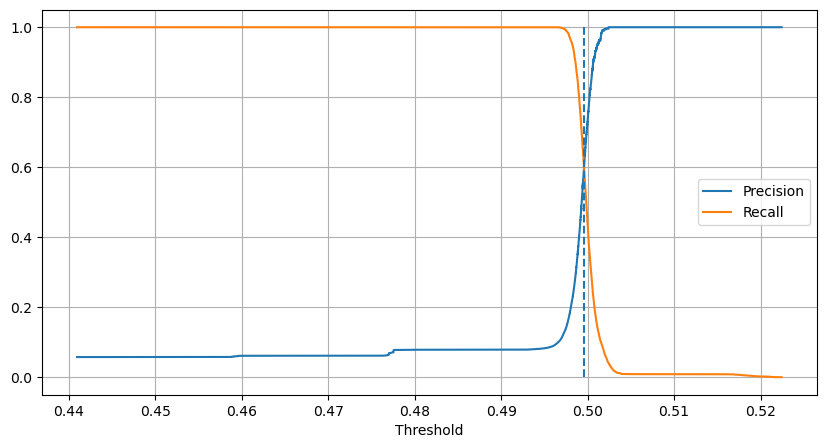

In [105]:
y_pred_probs_train = ada.predict_proba(X_train)[:, 1]

threshold = find_threshold(y_pred_probs_train, y_train)

threshold

confusion_matrix:
Accuracy: 90.22388217172038%
Recall: 84.34588147595974%
Precision: 34.944410129709695%


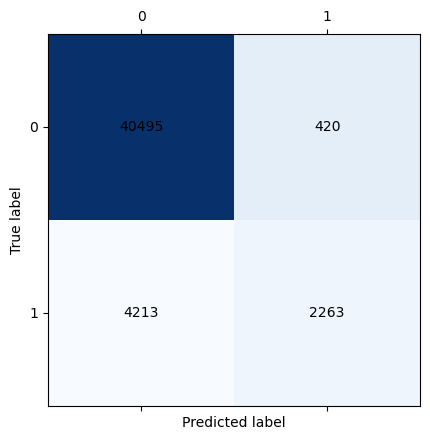

In [106]:
y_pred_probs_test = ada.predict_proba(X_test)[:, 1]

y_pred_test = y_pred_probs_test >= 0.49885

get_metrics(y_test, y_pred_test)

In [107]:
top_col_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': ada.feature_importances_})
top_col_df.sort_values('Importance', ascending=False, inplace=True)
top_col_df.head(10)


,Feature,Importance
3,cap_loss,0.204
2,cap_gain,0.160
0,age,0.110
6,weeks_worked,0.044
1,wage_hr,0.042
4,dividend,0.042
5,num_ppl_worked,0.014
187,tax_filer_stat_ Nonfiler,0.006
188,tax_filer_stat_ Single,0.006
125,marital_ Widowed,0.004
